<a href="https://colab.research.google.com/github/bhavyaKumawat/tensorflow-datasets/blob/main/AlzheimerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [1]:
import zipfile
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf
from matplotlib.image import imread

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

## Download Kaggle Datasets
[ Kaggle Dataset](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir /root/.kaggle
! cp 'drive/MyDrive/Colab Notebooks/kaggle.json' '/root/.kaggle/kaggle.json'

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
zip_file = "alzheimers-dataset-4-class-of-images.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [6]:
data_dir = pathlib.Path("Alzheimer_s Dataset")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

### Train and Test Dataset size

In [7]:
os.listdir(data_dir)

['test', 'train']

In [8]:
for category in ["train", "test"]:
  print(f"{category}")
  path = os.path.join(data_dir, category)
  for class_ in os.listdir(path):
    print(f"{class_} : {len(os.listdir(os.path.join(path, class_)))}")

train
VeryMildDemented : 1792
ModerateDemented : 52
MildDemented : 717
NonDemented : 2560
test
VeryMildDemented : 448
ModerateDemented : 12
MildDemented : 179
NonDemented : 640


## Plot some images in dataset

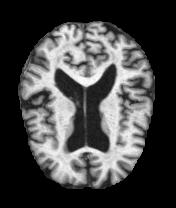

In [9]:
train = glob.glob(f"{train_dir}/*/*")
img = PIL.Image.open(train[0])
img

In [10]:
img.size

(176, 208)

In [11]:
def file_to_ndarray(dir , index):
  example_name = os.listdir(dir)[index]
  file_name = os.path.join(dir, example_name)
  img = imread(file_name)
  return img

##Data augmentation

In [12]:
validation_split = 0.1

datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=validation_split
)

In [13]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 32,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(176, 176),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 8,
    subset='validation'
)


Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.


## Transfer Learning

In [14]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 44, 128)       0     

In [15]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss = CategoricalCrossentropy(), metrics=['accuracy'])

## Train the model

In [16]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // 8,
                    epochs=50, 
                    callbacks=callback)

Epoch 1/50
144/144 [==============================] - 30s 161ms/step - loss: 0.9808 - accuracy: 0.5727 - val_loss: 1.0705 - val_accuracy: 0.5317
Epoch 2/50
144/144 [==============================] - 21s 145ms/step - loss: 0.7493 - accuracy: 0.6704 - val_loss: 0.8733 - val_accuracy: 0.6091
Epoch 3/50
144/144 [==============================] - 21s 146ms/step - loss: 0.5967 - accuracy: 0.7527 - val_loss: 0.8563 - val_accuracy: 0.6290
Epoch 4/50
144/144 [==============================] - 21s 148ms/step - loss: 0.5444 - accuracy: 0.7837 - val_loss: 0.7405 - val_accuracy: 0.6726
Epoch 5/50
144/144 [==============================] - 21s 144ms/step - loss: 0.4906 - accuracy: 0.8052 - val_loss: 0.7728 - val_accuracy: 0.6488
Epoch 6/50
144/144 [==============================] - 21s 148ms/step - loss: 0.4584 - accuracy: 0.8209 - val_loss: 0.7857 - val_accuracy: 0.6468
Epoch 7/50
144/144 [==============================] - 21s 147ms/step - loss: 0.4258 - accuracy: 0.8355 - val_loss: 0.6563 - val_ac

## Training vs Validation accuracy

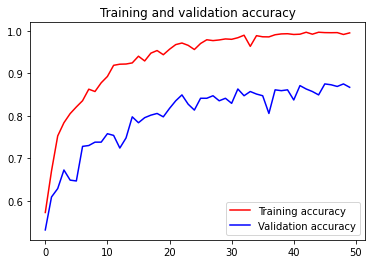

<Figure size 432x288 with 0 Axes>

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

##Test

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [19]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    target_size=(176, 176)
    )

Found 1279 images belonging to 4 classes.


In [20]:
test_generator.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [21]:
predictions = model.predict(test_generator)


40/40 [==============================] - 7s 173ms/step


In [22]:
# Predicted Labels
predictions.argmax(axis=-1)

array([0, 0, 0, ..., 3, 3, 2])

In [23]:
# True Labels
test_generator.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [24]:
correct = predictions.argmax(axis=-1) == test_generator.classes

In [25]:
accuracy = np.count_nonzero(correct)/ len(predictions)
accuracy

69.19468334636434